In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['axes.grid'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
import pandas as pd
import numpy as np

## Simulation based profit calculation instead of analytical calculation.

- Captures variability and uncertainty through Monte Carlo simulation, providing a more realistic representation of the system's behavior.
- More flexible and adaptable to complex systems with non-linear relationships and stochastic components.
- Can incorporate various sources of uncertainty and dynamic factors that affect the system over time.

However,

- Requires more computational resources and time compared to analytical methods, especially for large-scale simulations.
- Results may be subject to randomness and variability, requiring multiple runs to obtain reliable estimates.
- Complexity of implementation, especially if the simulation model is intricate and requires validation.

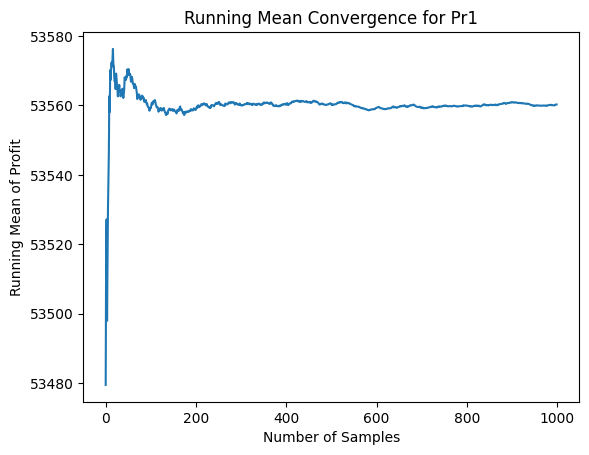

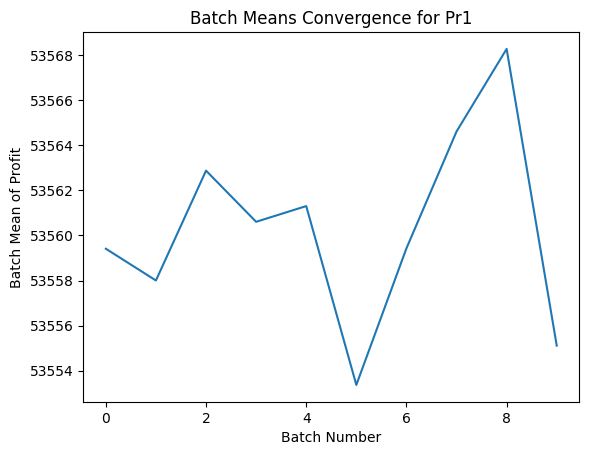

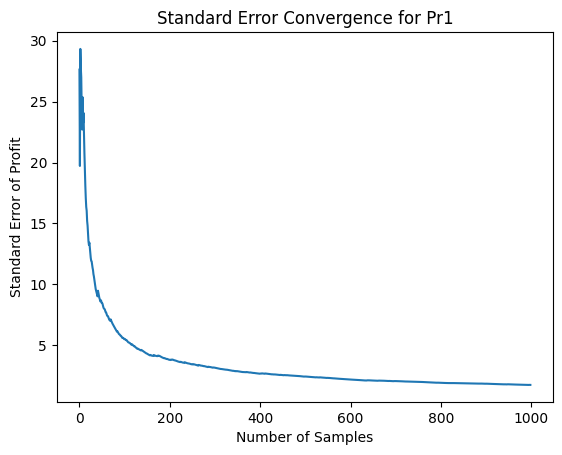

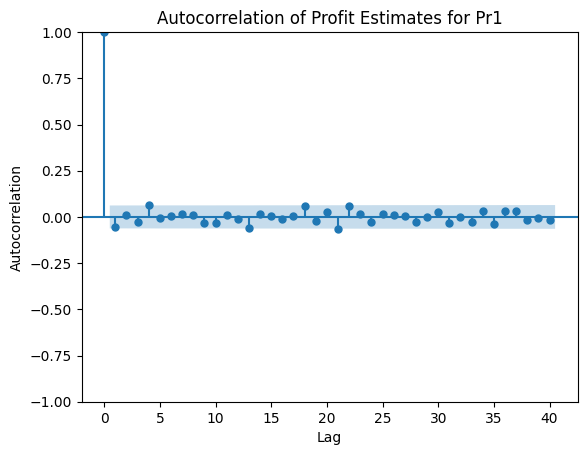

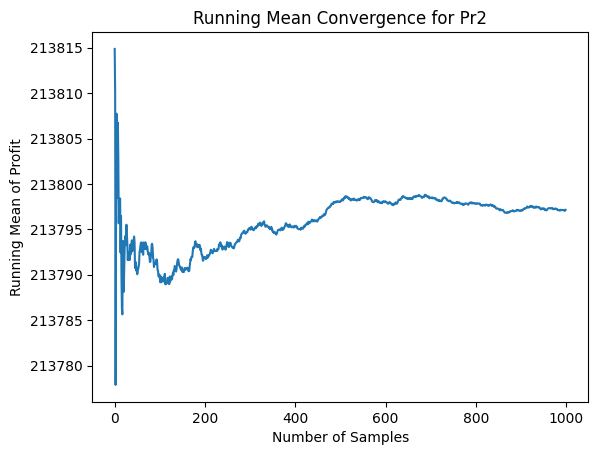

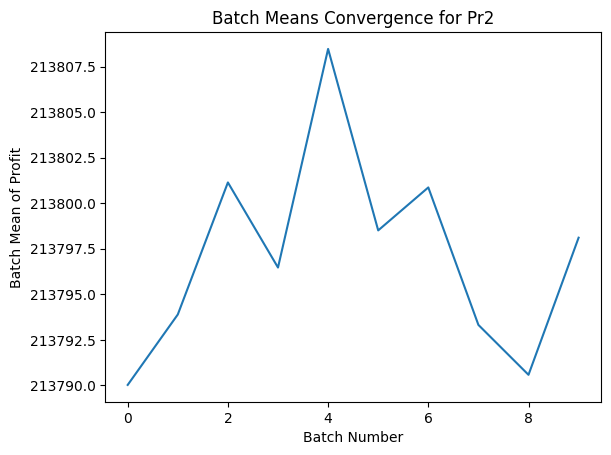

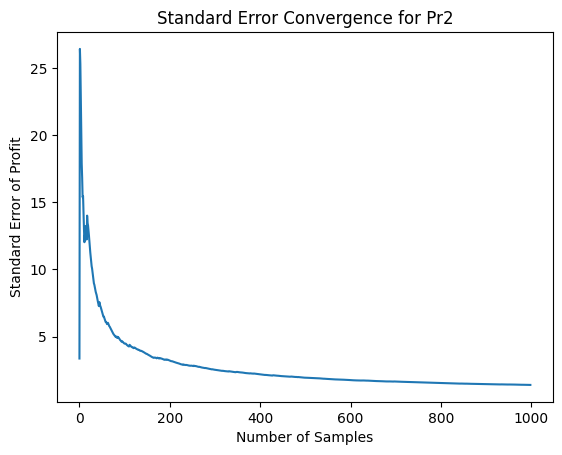

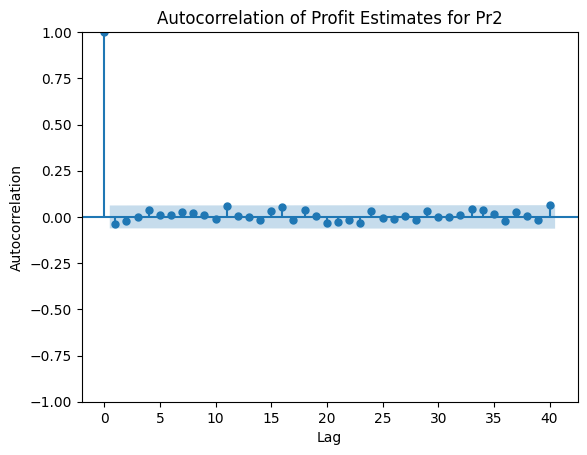

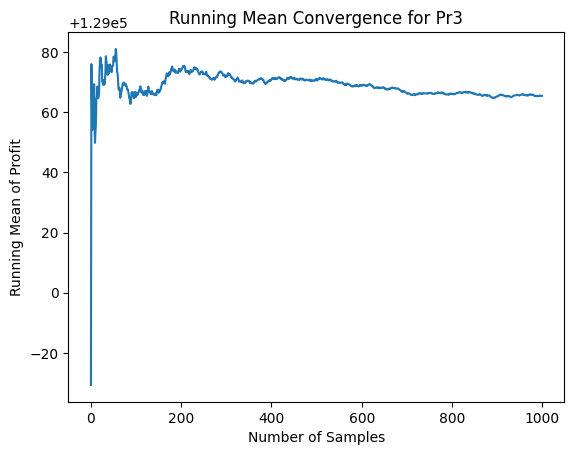

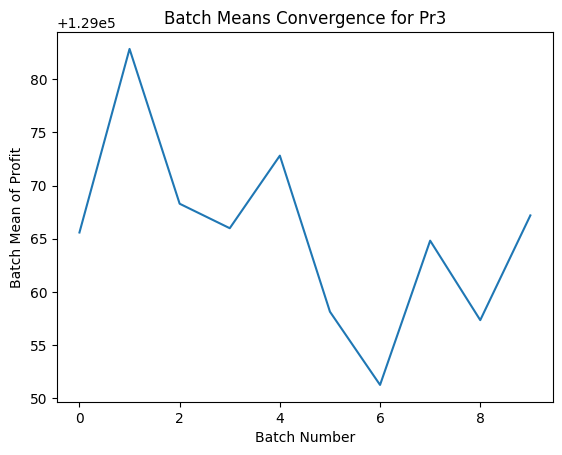

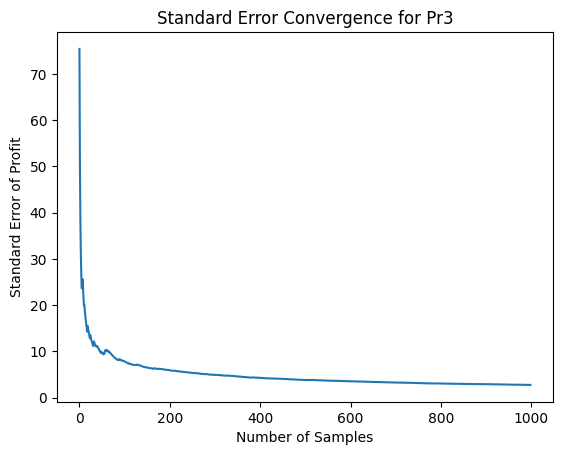

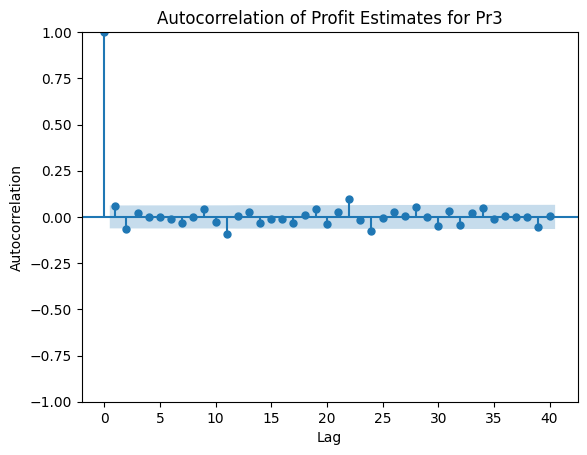

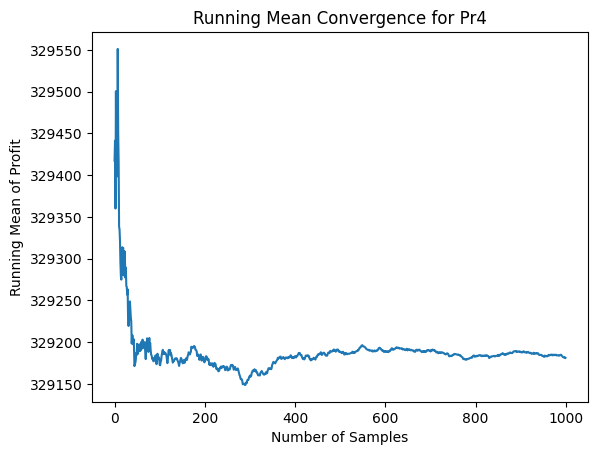

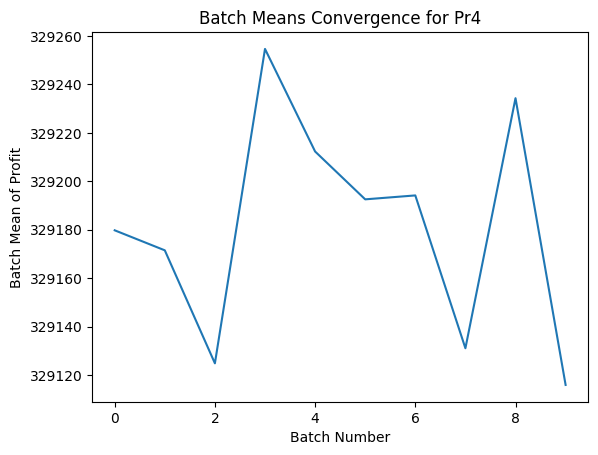

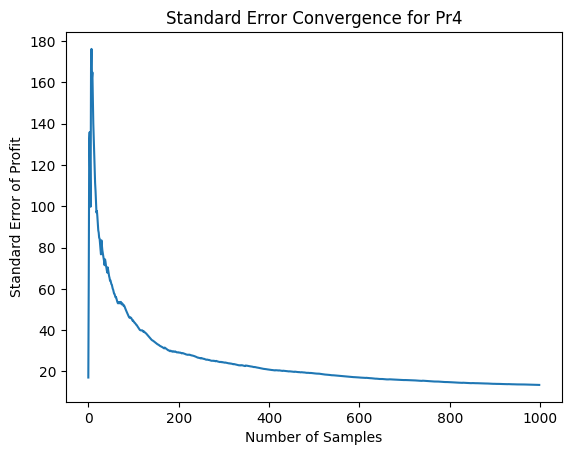

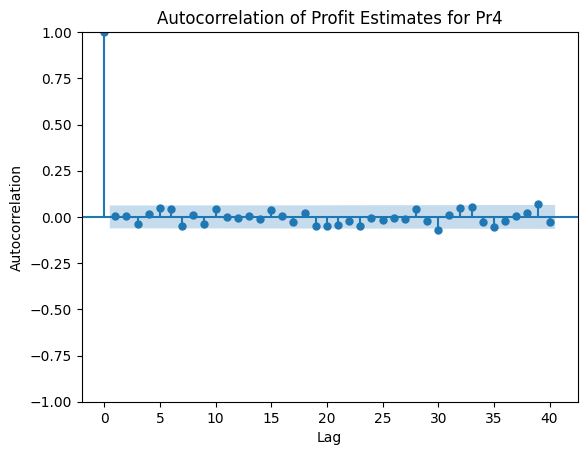

In [ ]:
def calculate_safety_stock(max_daily_sales, max_lead_time, avg_daily_sales, avg_lead_time):
    safety_stock = (max_daily_sales * max_lead_time) - (avg_daily_sales * avg_lead_time)
    return safety_stock

summary = {
    'Purchase Cost': [12, 7, 6, 37],
    'Lead Time': [9, 6, 15, 12],
    'Size': [0.57, 0.05, 0.53, 1.05],
    'Selling Price': [16.10, 8.60, 10.20, 68],
    'Starting Stock': [2750, 22500, 5200, 1400],
    'Ch': [0.2 * 12, 0.2 * 7, 0.2 * 6, 0.2 * 37],
    'Co': [1000, 1200, 1000, 1200],
    'Probability': [0.76, 1.00, 0.70, 0.23],
    'Mean Demand (Lead Time)': [103.50, 648.55, 201.68, 150.06],
    'Std. Dev. of Demand (Lead Time)': [37.32, 26.45, 31.08, 3.21],
    'Expected Demand (Lead Time)': [705, 3891, 2266, 785]
}

class Product:
    def __init__(self, i):
        self.mean = np.mean([np.log(j) for j in [summary['Expected Demand (Lead Time)'][i - 1]] if j > 0])
        self.sd = np.std([np.log(j) for j in [summary['Expected Demand (Lead Time)'][i - 1]] if j > 0])
        self.i = i
        self.unit_cost = summary['Purchase Cost'][i - 1]
        self.lead_time = summary['Lead Time'][i - 1]
        self.size = summary['Size'][i - 1]
        self.selling_price = summary['Selling Price'][i - 1]
        self.holding_cost = summary['Ch'][i - 1]
        self.ordering_cost = summary['Co'][i - 1]
        self.probability = summary['Probability'][i - 1]
        self.starting_stock = summary['Starting Stock'][i - 1]
        self.mean_demand_lead_time = summary['Mean Demand (Lead Time)'][i - 1]
        self.std_dev_demand_lead_time = summary['Std. Dev. of Demand (Lead Time)'][i - 1]
        self.expected_demand_lead_time = summary['Expected Demand (Lead Time)'][i - 1]

def daily_demand(mean, sd, probability):
    if np.random.uniform(0, 1) > probability:
        return 0
    else:
        return np.exp(np.random.normal(mean, sd))

def monte_carlo_ray(M, product, review_period=30, z_score=1.65):
    inventory = product.starting_stock
    mean = product.mean
    sd = product.sd
    lead_time = product.lead_time
    probability = product.probability
    demand_lead = product.expected_demand_lead_time

    # Importance sampling parameters
    high_demand_value = 2 * mean
    weights = [0.8, 0.2]
    means = [mean, high_demand_value]
    sds = [sd, sd]


    daily_sales = [np.random.normal(means[i], sds[i]) for i in np.random.choice(len(weights), size=365, p=weights)]  n
    max_daily_sales = np.max(daily_sales)
    avg_daily_sales = np.mean(daily_sales)


    max_lead_time = lead_time
    avg_lead_time = np.mean(summary['Lead Time'])


    safety_stock = calculate_safety_stock(max_daily_sales, max_lead_time, avg_daily_sales, avg_lead_time)


    q = 0
    stock_out = 0
    counter = 0
    order_placed = False
    data = {'inv_level': [], 'daily_demand': [], 'units_sold': [], 'units_lost': [], 'orders': [], 'reorder_quantities': []}

    for day in range(1, 365):

        day_demand = [np.random.normal(means[i], sds[i]) for i in np.random.choice(len(weights), size=365, p=weights)]
        if day_demand != 0:
            data['daily_demand'].append(day_demand)

        if day % review_period == 0:
            q = max(0, safety_stock + demand_lead - inventory)
            q = max(q, int(0.2 * mean))
            order_placed = True
            data['orders'].append(q)
            data['reorder_quantities'].append(q)

        if order_placed:
            counter += 1

        if counter == lead_time:
            inventory += q
            order_placed = False
            counter = 0

        for demand in day_demand:
            if inventory - demand >= 0:
                data['units_sold'].append(demand)
                inventory -= demand
            else:
                data['units_sold'].append(inventory)
                data['units_lost'].append(demand - inventory)
                inventory = 0
                stock_out += 1

            data['inv_level'].append(inventory)

    return data

def calculate_profit(data, product):
    unit_cost = product.unit_cost
    selling_price = product.selling_price
    holding_cost = product.holding_cost
    order_cost = product.ordering_cost
    size = product.size
    days = 365

    revenue = sum(data['units_sold']) * selling_price
    Co = len(data['orders']) * order_cost
    Ch = sum(data['inv_level']) * holding_cost * size / days
    cost = sum(data['orders']) * unit_cost

    profit = revenue - cost - Co - Ch

    return profit

products = [Product(i) for i in range(1, 5)]
results = {}

for product in products:
    profit_list = []
    reorder_quantity_list = []
    for _ in range(1000):
        data = MCS(M=10000, product=product)
        profit = calculate_profit(data, product)
        profit_list.append(profit)
        reorder_quantity_list.extend(data['reorder_quantities'])
    results[f'Pr{product.i}'] = {
        'profit_list': profit_list,
        'reorder_quantity_list': reorder_quantity_list
    }

for product_name, result in results.items():
    profit_list = result['profit_list']


    def plot_running_mean(estimates):
        running_mean = np.cumsum(estimates) / np.arange(1, len(estimates) + 1)
        plt.plot(running_mean)
        plt.xlabel('Number of Samples')
        plt.ylabel('Running Mean of Profit')
        plt.title(f'Running Mean Convergence for {product_name}')
        plt.show()

    plot_running_mean(profit_list)


    def batch_means(estimates, batch_size):
        num_batches = len(estimates) // batch_size
        batch_means = [np.mean(estimates[i * batch_size:(i + 1) * batch_size]) for i in range(num_batches)]
        return batch_means

    batch_size = 100
    batch_means_list = batch_means(profit_list, batch_size)

    plt.plot(batch_means_list)
    plt.xlabel('Batch Number')
    plt.ylabel('Batch Mean of Profit')
    plt.title(f'Batch Means Convergence for {product_name}')
    plt.show()


    def standard_error(estimates):
        return np.std(estimates) / np.sqrt(len(estimates))

    def plot_standard_error(estimates):
        errors = [standard_error(estimates[:i]) for i in range(2, len(estimates) + 1)]
        plt.plot(errors)
        plt.xlabel('Number of Samples')
        plt.ylabel('Standard Error of Profit')
        plt.title(f'Standard Error Convergence for {product_name}')
        plt.show()

    plot_standard_error(profit_list)


    def plot_autocorrelation(estimates):
        sm.graphics.tsa.plot_acf(estimates, lags=40)
        plt.xlabel('Lag')
        plt.ylabel('Autocorrelation')
        plt.title(f'Autocorrelation of Profit Estimates for {product_name}')
        plt.show()

    plot_autocorrelation(profit_list)

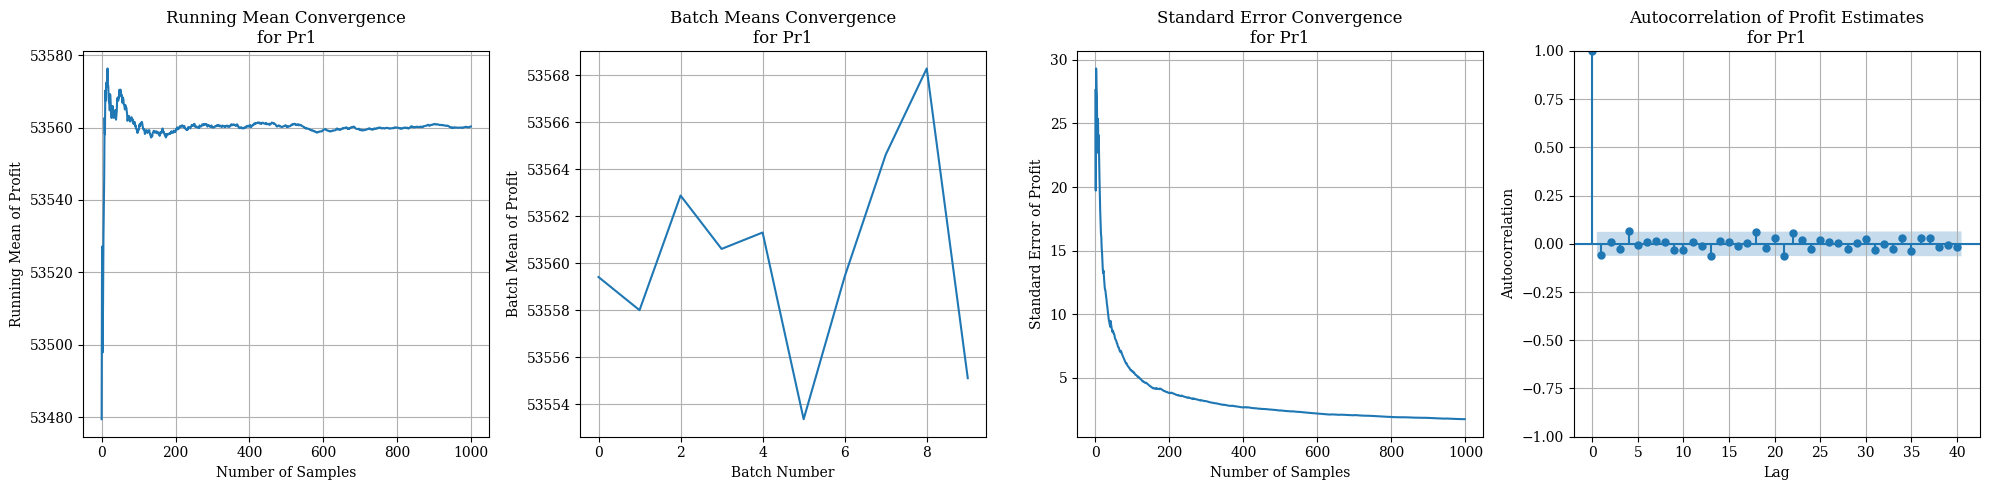

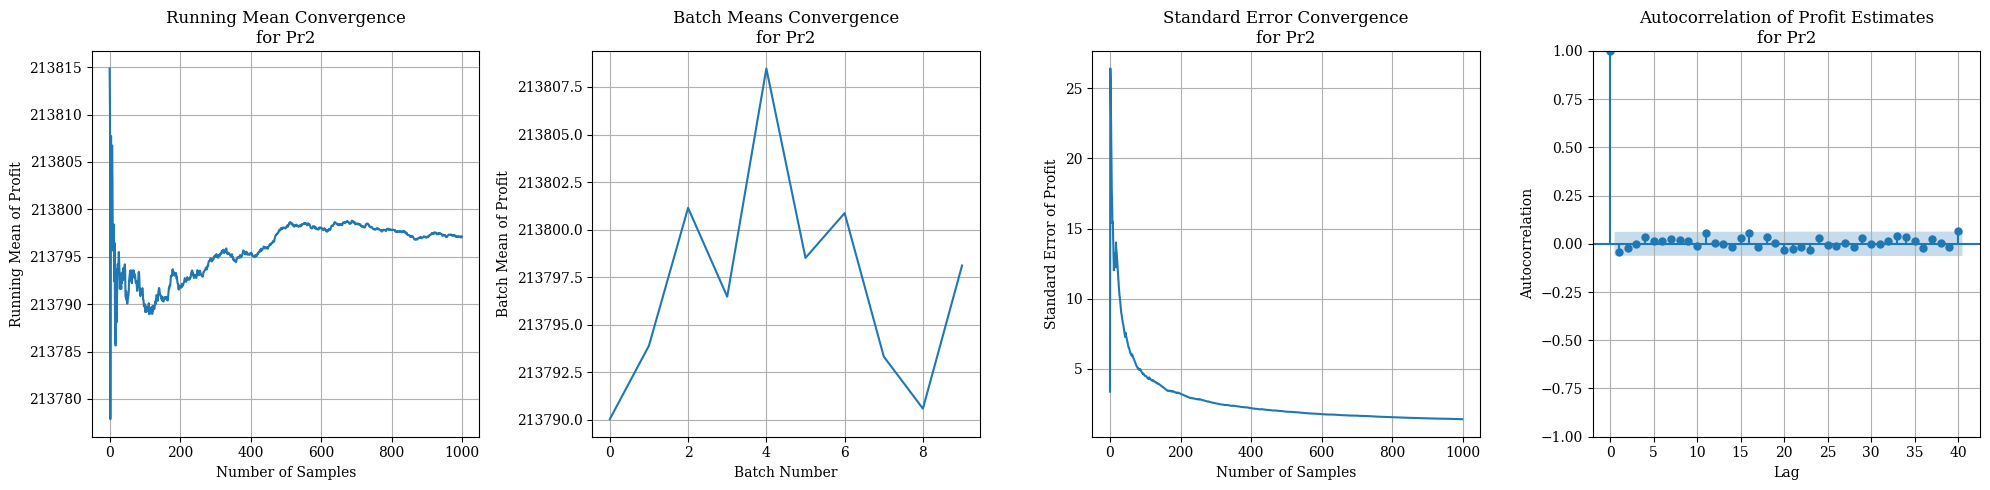

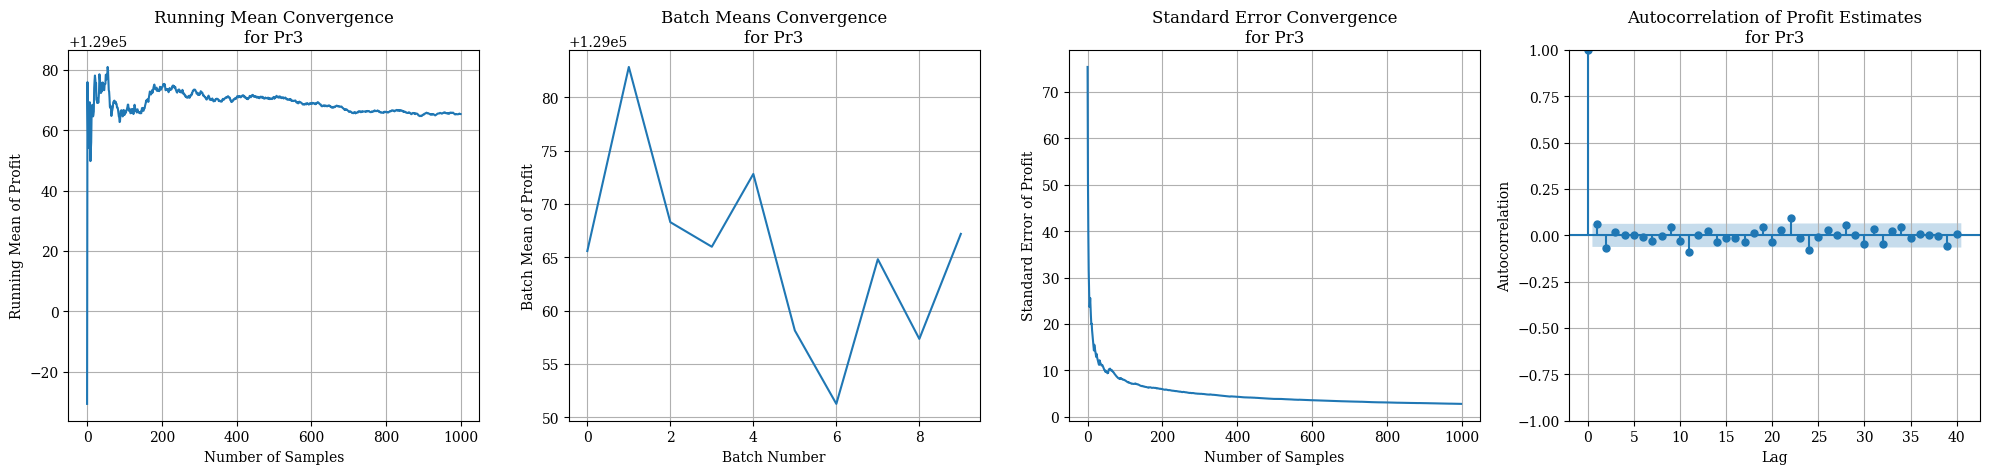

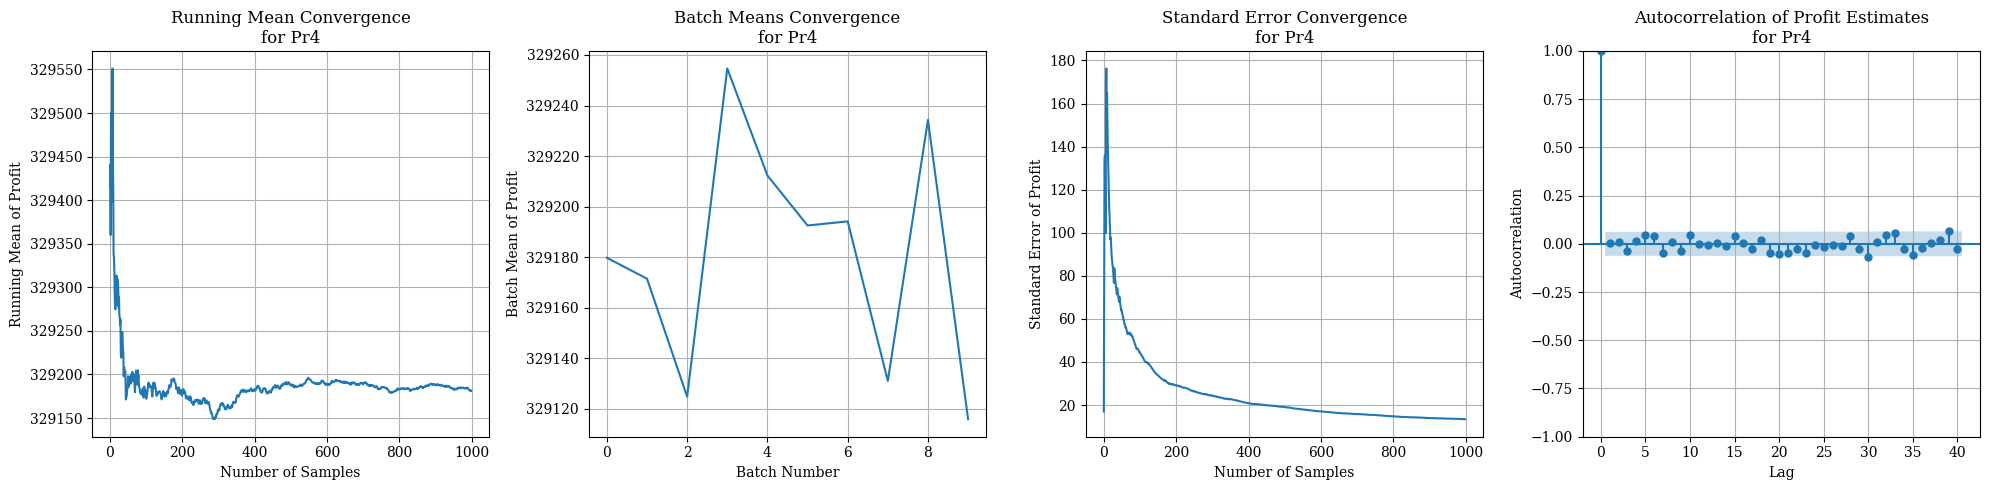

In [ ]:
# Plotting convergence checks
for product_name, result in results.items():
    profit_list = result['profit_list']

    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    # Running Mean Plot
    running_mean = np.cumsum(profit_list) / np.arange(1, len(profit_list) + 1)
    axes[0].plot(running_mean)
    axes[0].set_xlabel('Number of Samples')
    axes[0].set_ylabel('Running Mean of Profit')
    axes[0].set_title(f'Running Mean Convergence\nfor {product_name}')

    # Batch Means Plot
    batch_size = 100  # Adjust batch size as needed
    num_batches = len(profit_list) // batch_size
    batch_means = [np.mean(profit_list[i * batch_size:(i + 1) * batch_size]) for i in range(num_batches)]
    axes[1].plot(batch_means)
    axes[1].set_xlabel('Batch Number')
    axes[1].set_ylabel('Batch Mean of Profit')
    axes[1].set_title(f'Batch Means Convergence\nfor {product_name}')

    # Standard Error Plot
    standard_errors = [np.std(profit_list[:i]) / np.sqrt(i) for i in range(2, len(profit_list) + 1)]
    axes[2].plot(standard_errors)
    axes[2].set_xlabel('Number of Samples')
    axes[2].set_ylabel('Standard Error of Profit')
    axes[2].set_title(f'Standard Error Convergence\nfor {product_name}')

    # Autocorrelation Plot
    sm.graphics.tsa.plot_acf(profit_list, lags=40, ax=axes[3])
    axes[3].set_xlabel('Lag')
    axes[3].set_ylabel('Autocorrelation')
    axes[3].set_title(f'Autocorrelation of Profit Estimates\nfor {product_name}')

    plt.tight_layout()
    plt.show()